# Эталонный датасет

In [ ]:
import pandas as pd
import json

# Загрузка эталонного датасета
reference_df = pd.read_excel("эталонный_датасет.xlsx")  # Столбцы: Skill, CourseLink

reference_df.head()

,skill,course,course_link
0,excel,Цифровая грамотность для инженерных и техничес...,https://openedu.ru/course/hse/DIGLIT_4/?sessio...
1,excel,Комплекс инструментов для бизнес-анализа. MS E...,https://openedu.ru/course/misis/EXL/?session=s...
2,excel,Практики работы с ETL-инструментами на бизнес-...,https://openedu.ru/course/spbu/ECON_ANALYS3/?s...
3,excel,Введение в анализ данных сайтов,https://openedu.ru/course/spbu/SITE_ANALYS/?se...
4,power bi,Практики создания аналитических панелей с помо...,https://openedu.ru/course/spbu/ECON_ANALYS4/?s...


In [ ]:
import pandas as pd
import json

# Загрузка файла
with open('фин_рек_вект_sorted.json', encoding='utf-8-sig') as f:
    data = json.load(f)

# Преобразование в DataFrame
records = []
for entry in data:
    skill = entry['UncoveredSkill']
    for course in entry['SortedCourses']:
        records.append({
            'skill': skill,
            'course_title': course.get('CourseTitle', ''),
            'course_link': course.get('CourseLink', ''),
            'cosine_similarity': course.get('CosineSimilarity', None)
        })

df = pd.DataFrame(records)

In [ ]:
df.head(3)

,skill,course_title,course_link,cosine_similarity
0,a/b тесты,Аналитика технологических данных,https://openedu.ru/course/stankin/ATD/?session...,1.000000
1,a/b тесты,Теория клеточных автоматов,https://openedu.ru/course/mephi/cel_auto/?sess...,0.846384
2,a/b тесты,Аналитическая химия. Часть 2. Инструментальные...,https://openedu.ru/course/urfu/ANALYTCHEM2/?se...,0.822586


## Векторная близость

In [ ]:
import pandas as pd
import numpy as np
import json

# 📄 Загрузка эталона
ref_df = pd.read_excel("эталонный_датасет.xlsx")
ref_df.dropna(subset=["skill", "course_link"], inplace=True)
reference_dict = ref_df.groupby("skill")["course_link"].apply(set).to_dict()

# 📄 Загрузка рекомендаций
with open("фин_рек_вект_sorted.json", "r", encoding="utf-8") as f:
    rec_data = json.load(f)

# 📌 Словарь рекомендаций
rec_dict = {
    entry["UncoveredSkill"]: [course["CourseLink"] for course in entry["SortedCourses"]]
    for entry in rec_data
}

# 📊 Подсчёт метрик
results = []

for skill, recommended in rec_dict.items():
    true = reference_dict.get(skill)
    if not true:
        continue

    top5 = recommended[:5]
    hits_top5 = [r for r in top5 if r in true]
    hits_all = [r for r in recommended if r in true]

    results.append({
        "Навык": skill,
        "Эталонных курсов": len(true),
        "Рекомендовано": len(recommended),
        "TP в топ-5": len(hits_top5),
        "TP всего": len(hits_all),
        "Precision@N": len(hits_all) / len(recommended) if recommended else 0,
        "Recall@N": len(hits_all) / len(true),
    })

df = pd.DataFrame(results)

# 📌 Функция бутстрэпа для доверительных интервалов
def bootstrap_ci(data, n_bootstraps=10000, ci=95):
    np.random.seed(42)
    boot_samples = [np.mean(np.random.choice(data, size=len(data), replace=True)) for _ in range(n_bootstraps)]
    lower = np.percentile(boot_samples, (100 - ci) / 2)
    upper = np.percentile(boot_samples, 100 - (100 - ci) / 2)
    return round(lower,4), round(upper,4)

# 📋 Macro и Micro-оценки
macro_row = {"Навык": "ИТОГО (Macro)"}
micro_row = {"Навык": "ИТОГО (Micro)"}

metrics = ["Precision@N", "Recall@N"]

for metric in metrics:
    values = df.loc[~df["Навык"].str.startswith("ИТОГО"), metric].astype(float).dropna().values
    macro_val = round(np.mean(values), 4)
    micro_val = round(np.sum(values) / len(values), 4)
    macro_row[metric] = macro_val
    micro_row[metric] = micro_val

    ci_low, ci_high = bootstrap_ci(values)
    macro_row[f"{metric}_CI"] = f"[{ci_low}, {ci_high}]"

# Добавляем итоговые строки с помощью pd.concat
df = pd.concat([df, pd.DataFrame([macro_row, micro_row])], ignore_index=True).fillna("")

# 📋 Вывод таблицы с интервалами
display(df)

,Навык,Эталонных курсов,Рекомендовано,TP в топ-5,TP всего,Precision@N,Recall@N,Precision@N_CI,Recall@N_CI
0,a/b тесты,2.0,4.0,2.0,2.0,0.50000,1.000000,,
1,api,2.0,1.0,1.0,1.0,1.00000,0.500000,,
2,docker scikit learn,1.0,1.0,1.0,1.0,1.00000,1.000000,,
3,etl,1.0,1.0,1.0,1.0,1.00000,1.000000,,
4,excel,4.0,5.0,3.0,3.0,0.60000,0.750000,,
5,javascript,1.0,1.0,1.0,1.0,1.00000,1.000000,,
6,numpy,3.0,1.0,1.0,1.0,1.00000,0.333333,,
7,power bi,1.0,1.0,1.0,1.0,1.00000,1.000000,,
8,большие данные,11.0,29.0,5.0,11.0,0.37931,1.000000,,
9,язык программирования r,4.0,4.0,4.0,4.0,1.00000,1.000000,,


In [ ]:
from scipy.stats import shapiro
import numpy as np

precision_n = np.array([0.5, 1.0, 1.0, 1.0, 0.6, 1.0, 1.0, 1.0, 0.3793, 1.0])
stat, p = shapiro(precision_n)
print(f'Shapiro-Wilk Test: statistic={stat}, p-value={p}')


Shapiro-Wilk Test: statistic=0.6518175250078504, p-value=0.0002307934492043708


In [ ]:
import numpy as np

precision_n = np.array([0.5, 1.0, 1.0, 1.0, 0.6, 1.0, 1.0, 1.0, 0.3793, 1.0])
bootstrapped_means = []

# Количество повторений бутстрэпа (например, 10000)
n_bootstraps = 10000
np.random.seed(42)

for _ in range(n_bootstraps):
    sample = np.random.choice(precision_n, size=len(precision_n), replace=True)
    bootstrapped_means.append(np.mean(sample))

# Рассчитаем 95% доверительный интервал из бутстрэпа
ci_lower = np.percentile(bootstrapped_means, 2.5)
ci_upper = np.percentile(bootstrapped_means, 97.5)

print(f"Среднее Precision@N (бутстрэп): {np.mean(precision_n):.4f}")
print(f"95%-ый доверительный интервал (бутстрэп): [{ci_lower:.4f}, {ci_upper:.4f}]")


Среднее Precision@N (бутстрэп): 0.8479
95%-ый доверительный интервал (бутстрэп): [0.6859, 1.0000]


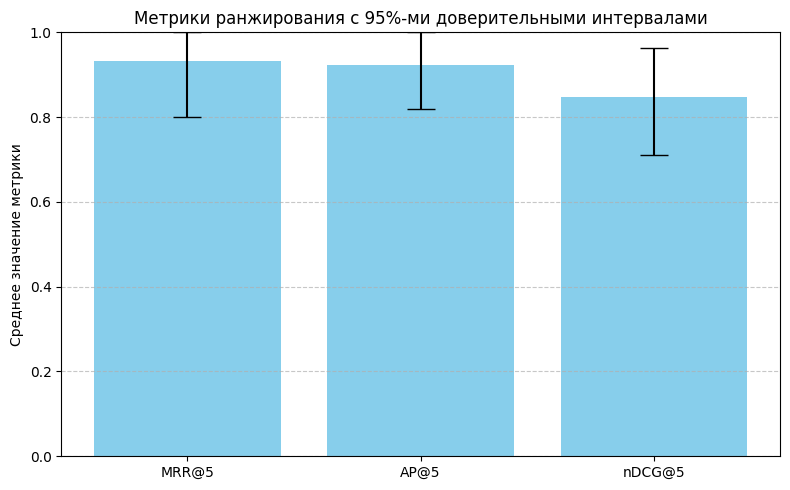

,Навык,MRR@5,AP@5,CG@5,DCG@5,nDCG@5,MRR@5_CI,AP@5_CI,nDCG@5_CI
0,a/b тесты,1.0000,0.7500,2,1.4307,0.8772,,,
1,api,1.0000,1.0000,1,1.0,0.6131,,,
2,docker scikit learn,1.0000,1.0000,1,1.0,1.0000,,,
3,etl,1.0000,1.0000,1,1.0,1.0000,,,
4,excel,0.3333,0.4778,3,1.3175,0.5143,,,
5,javascript,1.0000,1.0000,1,1.0,1.0000,,,
6,numpy,1.0000,1.0000,1,1.0,0.4693,,,
7,power bi,1.0000,1.0000,1,1.0,1.0000,,,
8,большие данные,1.0000,1.0000,5,2.9485,1.0000,,,
9,язык программирования r,1.0000,1.0000,4,2.5616,1.0000,,,


In [ ]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from math import log2
from IPython.display import display

# ⚙️ Настройки
K = 5

# Загрузка эталона
ref_df = pd.read_excel("эталонный_датасет.xlsx")
ref_df.dropna(subset=["skill", "course_link"], inplace=True)
reference_dict = ref_df.groupby("skill")["course_link"].apply(set).to_dict()

# Загрузка рекомендаций
with open("фин_рек_вект_sorted.json", "r", encoding="utf-8") as f:
    rec_data = json.load(f)

# Подготовка рекомендаций
rec_dict = {
    entry["UncoveredSkill"]: [c["CourseLink"] for c in entry["SortedCourses"][:K]]
    for entry in rec_data
}

# Метрики

def dcg(relevance):
    return sum((1 / log2(i + 2) if rel else 0) for i, rel in enumerate(relevance))

def ideal_dcg(n_relevant):
    return sum((1 / log2(i + 2)) for i in range(min(n_relevant, K)))

def ap_at_k(relevance):
    hits = 0
    score = 0
    for i, rel in enumerate(relevance):
        if rel:
            hits += 1
            score += hits / (i + 1)
    return score / min(sum(relevance), K) if sum(relevance) else 0

metrics = []
for skill, recs in rec_dict.items():
    true_set = reference_dict.get(skill)
    if not true_set:
        continue

    relevance = [1 if link in true_set else 0 for link in recs]

    mrr = next((1 / (idx + 1) for idx, rel in enumerate(relevance) if rel), 0)
    ap = ap_at_k(relevance)
    cg = sum(relevance)
    dcg_val = dcg(relevance)
    idcg_val = ideal_dcg(len(true_set))
    ndcg = dcg_val / idcg_val if idcg_val > 0 else 0

    metrics.append({
        "Навык": skill,
        "MRR@5": round(mrr, 4),
        "AP@5": round(ap, 4),
        "CG@5": cg,
        "DCG@5": round(dcg_val, 4),
        "nDCG@5": round(ndcg, 4),
    })

# 📌 Bootstrap для интервальных оценок ранжирования
def bootstrap_ci(data, n_bootstraps=10000, ci=95):
    np.random.seed(42)
    boot_samples = [np.mean(np.random.choice(data, size=len(data), replace=True)) for _ in range(n_bootstraps)]
    lower = np.percentile(boot_samples, (100 - ci) / 2)
    upper = np.percentile(boot_samples, 100 - (100 - ci) / 2)
    return round(lower, 4), round(upper, 4)

# Интервальные оценки для агрегированных метрик
agg_metrics = {"Навык": "ИТОГО"}
intervals = {}
for metric in ["MRR@5", "AP@5", "nDCG@5"]:
    values = [m[metric] for m in metrics]
    mean_val = round(np.mean(values), 4)
    ci_low, ci_high = bootstrap_ci(values)
    agg_metrics[metric] = mean_val
    intervals[metric] = (mean_val, ci_low, ci_high)
    agg_metrics[f"{metric}_CI"] = f"[{ci_low}, {ci_high}]"

agg_metrics.update({"CG@5": "", "DCG@5": ""})
metrics.append(agg_metrics)

# 📊 Визуализация интервальных оценок
fig, ax = plt.subplots(figsize=(8, 5))
metric_names = intervals.keys()
means = [intervals[m][0] for m in metric_names]
lower_bounds = [intervals[m][1] for m in metric_names]
upper_bounds = [intervals[m][2] for m in metric_names]

ax.bar(metric_names, means, yerr=[np.array(means)-np.array(lower_bounds), np.array(upper_bounds)-np.array(means)], capsize=10, color='skyblue')
ax.set_ylabel('Среднее значение метрики')
ax.set_title('Метрики ранжирования с 95%-ми доверительными интервалами')
ax.set_ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Вывод
metrics_df = pd.DataFrame(metrics).fillna("")
display(metrics_df)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def bootstrap_ci(data, n_bootstraps=10000, ci=95):
    """Вычисление доверительного интервала через бутстрэп."""
    np.random.seed(42)
    boot_samples = [np.mean(np.random.choice(data, size=len(data), replace=True)) for _ in range(n_bootstraps)]
    lower = np.percentile(boot_samples, (100 - ci) / 2)
    upper = np.percentile(boot_samples, 100 - (100 - ci) / 2)
    mean = np.mean(boot_samples)
    return mean, round(lower, 4), round(upper, 4), boot_samples

def plot_bootstrap(data, metric_name):
    """Построение графика бутстрэпа по метрике."""
    mean, lower, upper, boot_samples = bootstrap_ci(data)

    plt.figure(figsize=(10, 6))
    plt.hist(boot_samples, bins=30, color='skyblue', edgecolor='black', alpha=0.7)

    plt.axvline(lower, color='red', linestyle='--', linewidth=2, label=f'2.5% = {lower:.2f}')
    plt.axvline(upper, color='red', linestyle='--', linewidth=2, label=f'97.5% = {upper:.2f}')
    plt.axvline(mean, color='blue', linestyle='-', linewidth=2, label=f'Mean = {mean:.2f}')

    plt.title(f'Бутстрэп-распределение {metric_name}')
    plt.xlabel(metric_name)
    plt.ylabel('Частота')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()


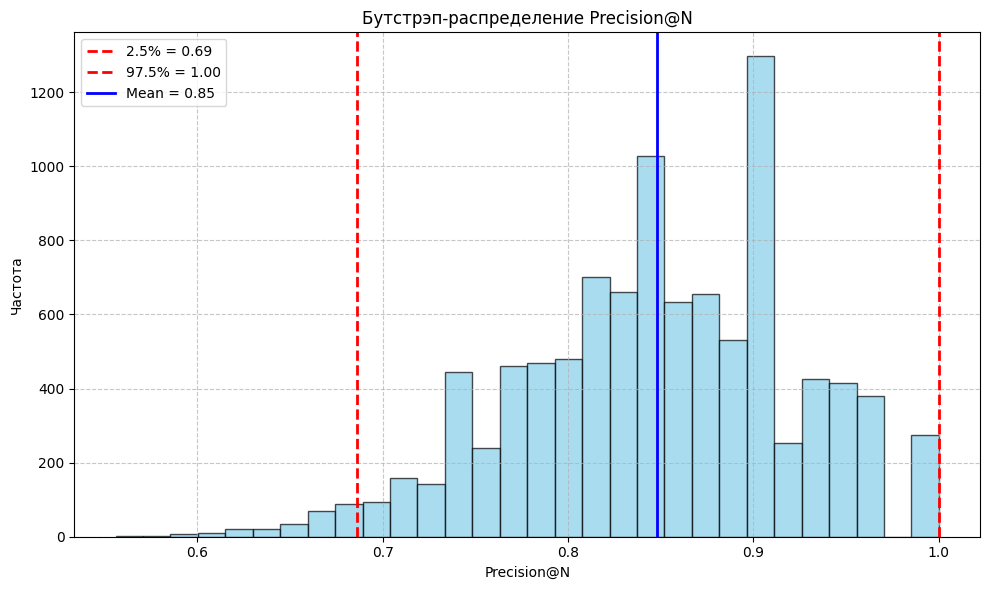

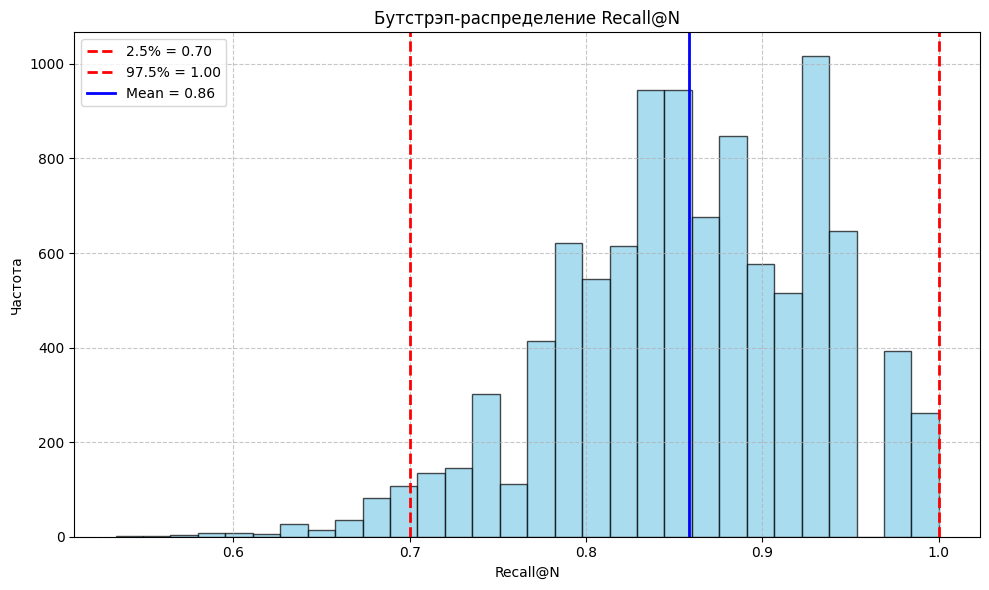

In [ ]:
# Отфильтровываем только реальные навыки, без итоговых строк
precision_values = df.loc[~df["Навык"].str.startswith("ИТОГО"), "Precision@N"].astype(float).dropna().values
recall_values = df.loc[~df["Навык"].str.startswith("ИТОГО"), "Recall@N"].astype(float).dropna().values

# Строим графики
plot_bootstrap(precision_values, "Precision@N")
plot_bootstrap(recall_values, "Recall@N")


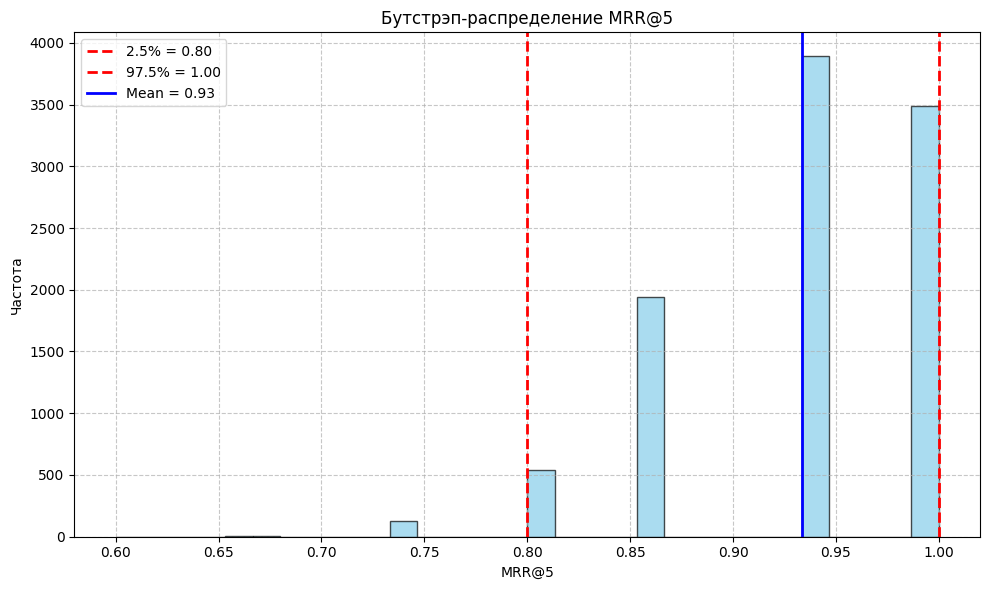

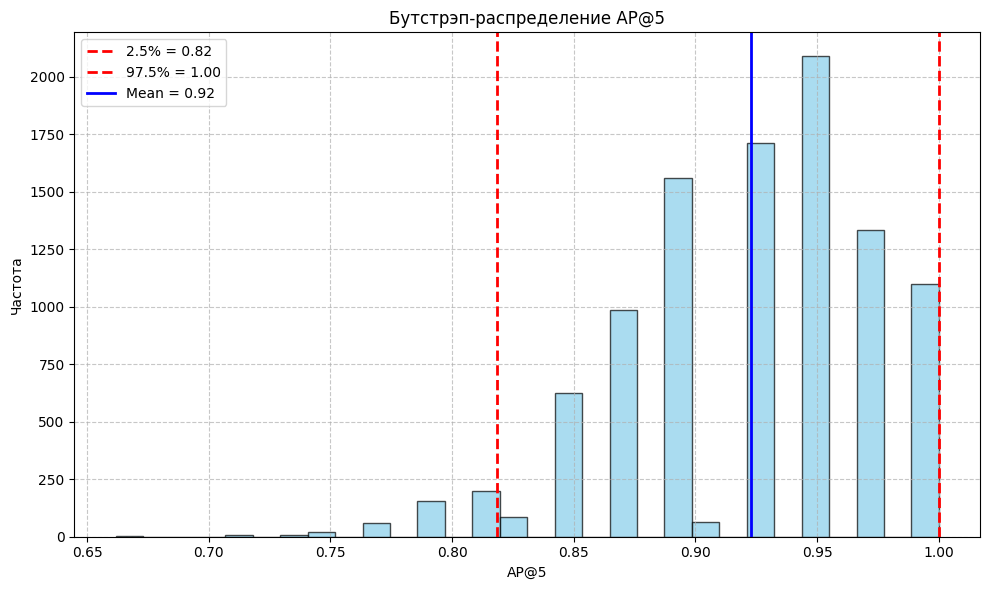

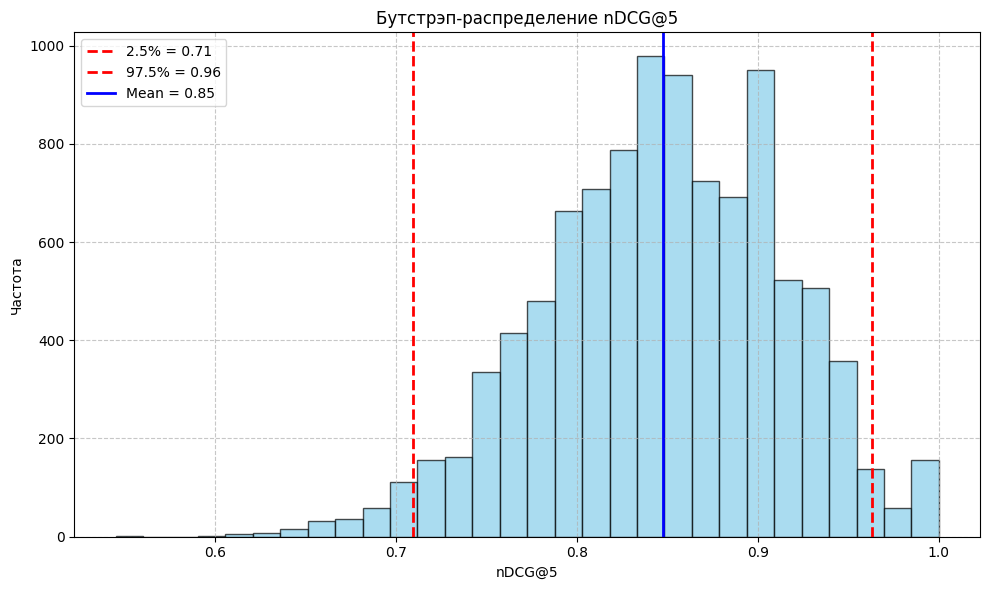

In [ ]:
# метрики ранжирования
plot_bootstrap(metrics_df.loc[metrics_df["Навык"] != "ИТОГО", "MRR@5"].astype(float).dropna().values, "MRR@5")
plot_bootstrap(metrics_df.loc[metrics_df["Навык"] != "ИТОГО", "AP@5"].astype(float).dropna().values, "AP@5")
plot_bootstrap(metrics_df.loc[metrics_df["Навык"] != "ИТОГО", "nDCG@5"].astype(float).dropna().values, "nDCG@5")


## Графовая близость

In [ ]:
import pandas as pd
import numpy as np
import json
from IPython.display import display

# Загрузка эталона
ref_df = pd.read_excel("эталонный_датасет.xlsx")
ref_df.dropna(subset=["skill", "course_link"], inplace=True)
reference_dict = ref_df.groupby("skill")["course_link"].apply(set).to_dict()

# Загрузка рекомендаций (графовая близость)
with open("фин_рек_граф_sorted.json", "r", encoding="utf-8") as f:
    rec_data = json.load(f)

# Подготовка словаря рекомендаций
rec_dict = {
    entry["UncoveredSkill"]: [course["CourseLink"] for course in entry["SortedCourses"]]
    for entry in rec_data
}

# Подсчёт метрик
results = []
total_tp_5 = 0
total_tp_n = 0
total_rec_5 = 0
total_rec_n = 0
total_true = 0

for skill, recommended in rec_dict.items():
    true = reference_dict.get(skill)
    if not true:
        continue

    top5 = recommended[:5]
    hits_top5 = [r for r in top5 if r in true]
    hits_all = [r for r in recommended if r in true]

    prec_n = len(hits_all) / len(recommended) if recommended else 0
    rec_n = len(hits_all) / len(true)

    total_tp_5 += len(hits_top5)
    total_tp_n += len(hits_all)
    total_rec_5 += 5
    total_rec_n += len(recommended)
    total_true += len(true)

    results.append({
        "Навык": skill,
        "Эталонных курсов": len(true),
        "Рекомендовано": len(recommended),
        "TP в топ-5": len(hits_top5),
        "TP всего": len(hits_all),
        "Precision@N": round(prec_n, 4),
        "Recall@N": round(rec_n, 4),
    })

df = pd.DataFrame(results)

# Функция бутстрэпа
def bootstrap_ci(data, n_bootstraps=10000, ci=95):
    np.random.seed(42)
    boot_samples = [np.mean(np.random.choice(data, size=len(data), replace=True)) for _ in range(n_bootstraps)]
    lower = np.percentile(boot_samples, (100 - ci) / 2)
    upper = np.percentile(boot_samples, 100 - (100 - ci) / 2)
    return round(lower, 4), round(upper, 4)

# Macro/Micro + CI (только Macro с интервалом)
macro_row = {"Навык": "ИТОГО (Macro)"}
micro_row = {"Навык": "ИТОГО (Micro)"}
metrics = ["Precision@N", "Recall@N"]

for metric in metrics:
    values = df[metric].astype(float).dropna().values
    macro_val = round(np.mean(values), 4)
    micro_val = round(np.sum(values) / len(values), 4)

    macro_row[metric] = macro_val
    micro_row[metric] = micro_val

    ci_low, ci_high = bootstrap_ci(values)
    macro_row[f"{metric}_CI"] = f"[{ci_low}, {ci_high}]"

df = pd.concat([df, pd.DataFrame([macro_row, micro_row])], ignore_index=True).fillna("")
display(df)


,Навык,Эталонных курсов,Рекомендовано,TP в топ-5,TP всего,Precision@N,Recall@N,Precision@N_CI,Recall@N_CI
0,javascript,1.0,1.0,1.0,1.0,1.0000,1.0000,,
1,api,2.0,1.0,1.0,1.0,1.0000,0.5000,,
2,excel,4.0,4.0,2.0,2.0,0.5000,0.5000,,
3,язык программирования r,4.0,3.0,3.0,3.0,1.0000,0.7500,,
4,power bi,1.0,1.0,1.0,1.0,1.0000,1.0000,,
5,etl,1.0,1.0,1.0,1.0,1.0000,1.0000,,
6,большие данные,11.0,29.0,5.0,11.0,0.3793,1.0000,,
7,a/b тесты,2.0,4.0,2.0,2.0,0.5000,1.0000,,
8,ИТОГО (Macro),,,,,0.7974,0.8438,"[0.6099, 0.9375]","[0.6875, 0.9688]"
9,ИТОГО (Micro),,,,,0.7974,0.8438,,


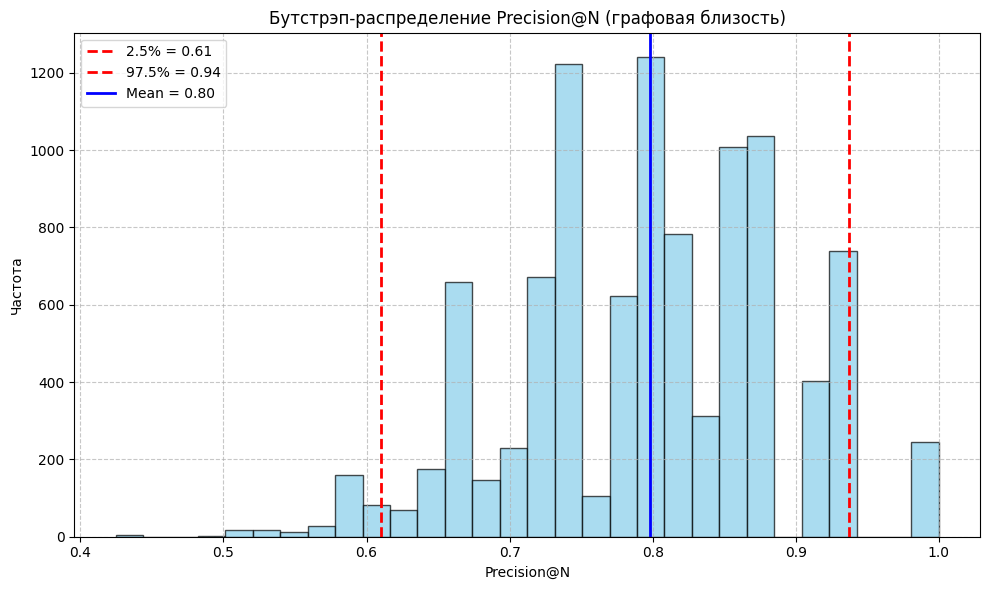

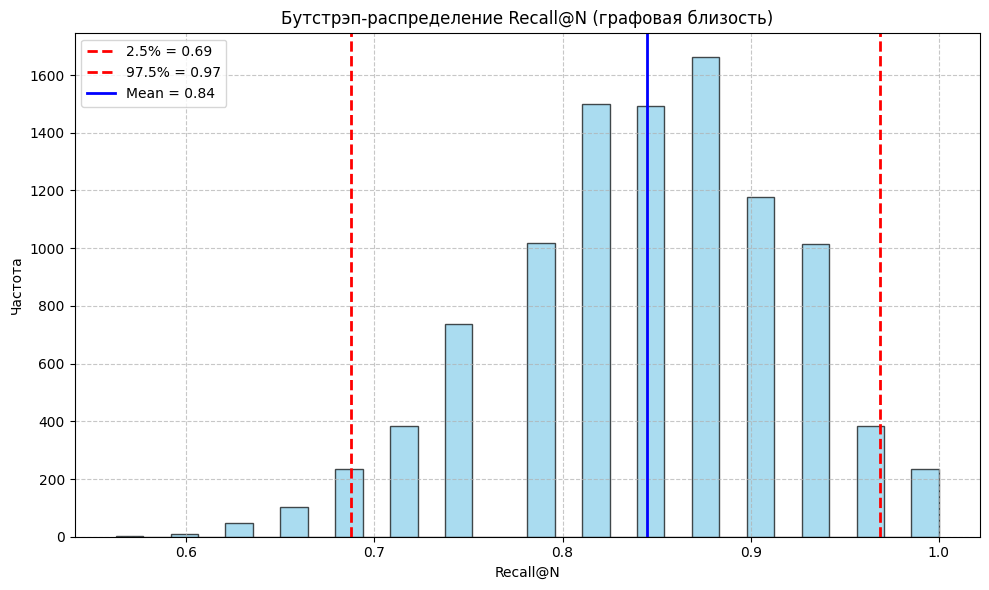

In [ ]:
import matplotlib.pyplot as plt

# Функция графика
def plot_bootstrap(metric_values, metric_name, n_bootstraps=10000):
    np.random.seed(42)
    boot_means = [
        np.mean(np.random.choice(metric_values, size=len(metric_values), replace=True))
        for _ in range(n_bootstraps)
    ]
    lower = np.percentile(boot_means, 2.5)
    upper = np.percentile(boot_means, 97.5)
    mean = np.mean(boot_means)

    plt.figure(figsize=(10, 6))
    plt.hist(boot_means, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    plt.axvline(lower, color='red', linestyle='--', linewidth=2, label=f'2.5% = {lower:.2f}')
    plt.axvline(upper, color='red', linestyle='--', linewidth=2, label=f'97.5% = {upper:.2f}')
    plt.axvline(mean, color='blue', linestyle='-', linewidth=2, label=f'Mean = {mean:.2f}')
    plt.title(f'Бутстрэп-распределение {metric_name} (графовая близость)')
    plt.xlabel(metric_name)
    plt.ylabel('Частота')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Только по навыкам (без "ИТОГО")
metric_values = df.loc[~df["Навык"].str.startswith("ИТОГО"), "Precision@N"].astype(float).dropna().values
plot_bootstrap(metric_values, "Precision@N")

metric_values = df.loc[~df["Навык"].str.startswith("ИТОГО"), "Recall@N"].astype(float).dropna().values
plot_bootstrap(metric_values, "Recall@N")


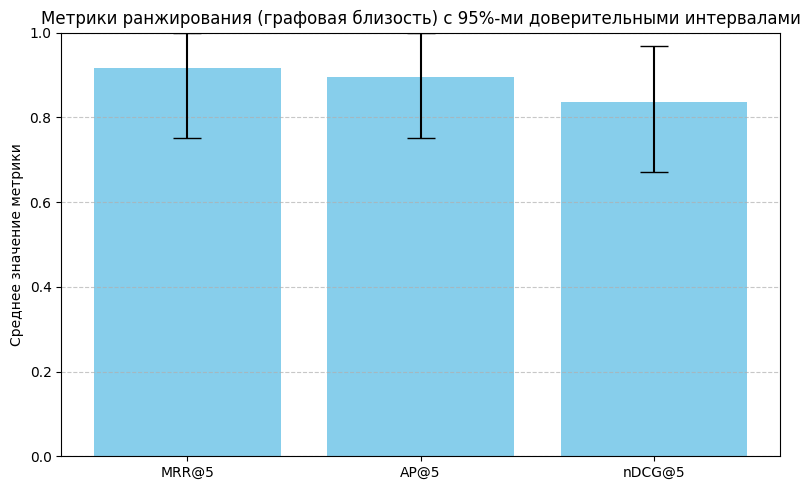

,Навык,MRR@5,AP@5,CG@5,DCG@5,nDCG@5,MRR@5_CI,AP@5_CI,nDCG@5_CI
0,javascript,1.0000,1.0000,1,1.0,1.0000,,,
1,api,1.0000,1.0000,1,1.0,0.6131,,,
2,excel,0.3333,0.4167,2,0.9307,0.3633,,,
3,язык программирования r,1.0000,1.0000,3,2.1309,0.8319,,,
4,power bi,1.0000,1.0000,1,1.0,1.0000,,,
5,etl,1.0000,1.0000,1,1.0,1.0000,,,
6,большие данные,1.0000,1.0000,5,2.9485,1.0000,,,
7,a/b тесты,1.0000,0.7500,2,1.4307,0.8772,,,
8,ИТОГО,0.9167,0.8958,,,0.8357,"[0.75, 1.0]","[0.75, 1.0]","[0.6708, 0.9693]"


In [ ]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from math import log2
from IPython.display import display

# ⚙️ Настройки
K = 5

# Загрузка эталона
ref_df = pd.read_excel("эталонный_датасет.xlsx")
ref_df.dropna(subset=["skill", "course_link"], inplace=True)
reference_dict = ref_df.groupby("skill")["course_link"].apply(set).to_dict()

# Загрузка рекомендаций (графовая близость)
with open("фин_рек_граф_sorted.json", "r", encoding="utf-8") as f:
    rec_data = json.load(f)

# Подготовка рекомендаций
rec_dict = {
    entry["UncoveredSkill"]: [c["CourseLink"] for c in entry["SortedCourses"][:K]]
    for entry in rec_data
}

# Метрики
def dcg(relevance):
    return sum((1 / log2(i + 2) if rel else 0) for i, rel in enumerate(relevance))

def ideal_dcg(n_relevant):
    return sum((1 / log2(i + 2)) for i in range(min(n_relevant, K)))

def ap_at_k(relevance):
    hits = 0
    score = 0
    for i, rel in enumerate(relevance):
        if rel:
            hits += 1
            score += hits / (i + 1)
    return score / min(sum(relevance), K) if sum(relevance) else 0

# Расчет метрик
metrics = []
for skill, recs in rec_dict.items():
    true_set = reference_dict.get(skill)
    if not true_set:
        continue

    relevance = [1 if link in true_set else 0 for link in recs]

    mrr = next((1 / (idx + 1) for idx, rel in enumerate(relevance) if rel), 0)
    ap = ap_at_k(relevance)
    cg = sum(relevance)
    dcg_val = dcg(relevance)
    idcg_val = ideal_dcg(len(true_set))
    ndcg = dcg_val / idcg_val if idcg_val > 0 else 0

    metrics.append({
        "Навык": skill,
        "MRR@5": round(mrr, 4),
        "AP@5": round(ap, 4),
        "CG@5": cg,
        "DCG@5": round(dcg_val, 4),
        "nDCG@5": round(ndcg, 4),
    })

# 📌 Bootstrap для интервальных оценок ранжирования
def bootstrap_ci(data, n_bootstraps=10000, ci=95):
    np.random.seed(42)
    boot_samples = [np.mean(np.random.choice(data, size=len(data), replace=True)) for _ in range(n_bootstraps)]
    lower = np.percentile(boot_samples, (100 - ci) / 2)
    upper = np.percentile(boot_samples, 100 - (100 - ci) / 2)
    return round(lower, 4), round(upper, 4)

# Интервальные оценки для агрегированных метрик
# Интервальные оценки для агрегированных метрик
agg_metrics = {"Навык": "ИТОГО"}
intervals = {}
for metric in ["MRR@5", "AP@5", "nDCG@5"]:
    values = [m[metric] for m in metrics if m["Навык"] != "ИТОГО"]  # ← FIX
    mean_val = round(np.mean(values), 4)
    ci_low, ci_high = bootstrap_ci(values)
    agg_metrics[metric] = mean_val
    intervals[metric] = (mean_val, ci_low, ci_high)
    agg_metrics[f"{metric}_CI"] = f"[{ci_low}, {ci_high}]"

agg_metrics.update({"CG@5": "", "DCG@5": ""})
metrics.append(agg_metrics)

# 📊 Визуализация интервальных оценок
fig, ax = plt.subplots(figsize=(8, 5))
metric_names = intervals.keys()
means = [intervals[m][0] for m in metric_names]
lower_bounds = [intervals[m][1] for m in metric_names]
upper_bounds = [intervals[m][2] for m in metric_names]

ax.bar(metric_names, means, yerr=[np.array(means)-np.array(lower_bounds), np.array(upper_bounds)-np.array(means)], capsize=10, color='skyblue')
ax.set_ylabel('Среднее значение метрики')
ax.set_title('Метрики ранжирования (графовая близость) с 95%-ми доверительными интервалами')
ax.set_ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Вывод таблицы
metrics_df = pd.DataFrame(metrics).fillna("")
display(metrics_df)

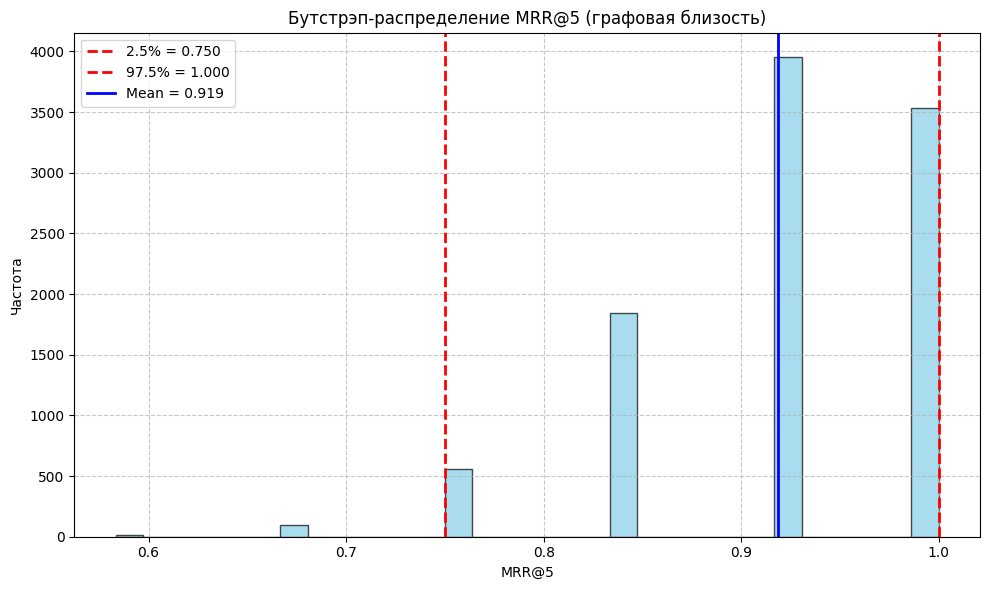

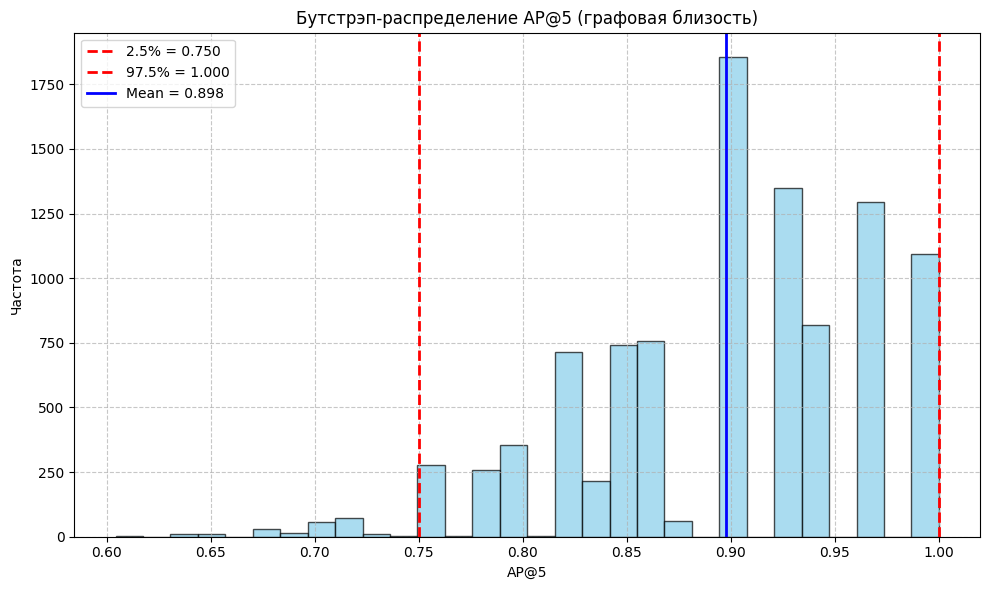

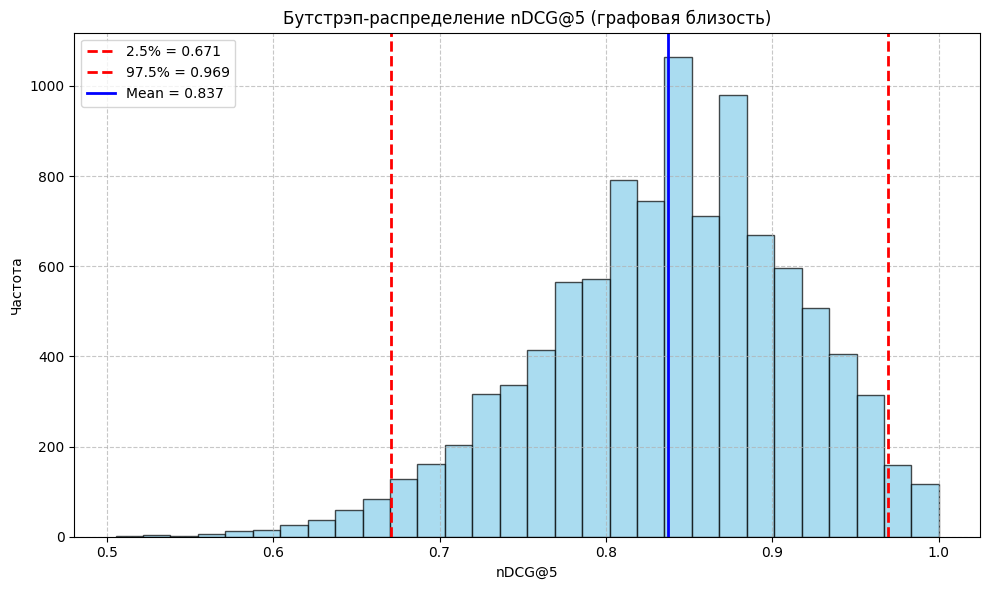

In [ ]:
# 📈 Функция построения распределения бутстрэпа
def plot_bootstrap(metric_values, metric_name, n_bootstraps=10000):
    np.random.seed(42)
    boot_means = [np.mean(np.random.choice(metric_values, size=len(metric_values), replace=True))
                  for _ in range(n_bootstraps)]

    lower = np.percentile(boot_means, 2.5)
    upper = np.percentile(boot_means, 97.5)
    mean = np.mean(boot_means)

    plt.figure(figsize=(10, 6))
    plt.hist(boot_means, bins=30, color='skyblue', edgecolor='black', alpha=0.7)

    plt.axvline(lower, color='red', linestyle='--', linewidth=2, label=f'2.5% = {lower:.3f}')
    plt.axvline(upper, color='red', linestyle='--', linewidth=2, label=f'97.5% = {upper:.3f}')
    plt.axvline(mean, color='blue', linestyle='-', linewidth=2, label=f'Mean = {mean:.3f}')

    plt.title(f'Бутстрэп-распределение {metric_name} (графовая близость)')
    plt.xlabel(metric_name)
    plt.ylabel('Частота')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 📊 Визуализация для всех метрик
for metric in ["MRR@5", "AP@5", "nDCG@5"]:
    values = [m[metric] for m in metrics if m["Навык"] != "ИТОГО"]
    plot_bootstrap(values, metric)


## Гибридная близость

In [ ]:
import pandas as pd
import numpy as np
import json
from IPython.display import display

# Загрузка эталона
ref_df = pd.read_excel("эталонный_датасет.xlsx")
ref_df.dropna(subset=["skill", "course_link"], inplace=True)
reference_dict = ref_df.groupby("skill")["course_link"].apply(set).to_dict()

# Загрузка рекомендаций (графовая близость)
with open("фин_рек_гибридн_sorted.json", "r", encoding="utf-8") as f:
    rec_data = json.load(f)

# Подготовка словаря рекомендаций
rec_dict = {
    entry["UncoveredSkill"]: [course["CourseLink"] for course in entry["SortedCourses"]]
    for entry in rec_data
}

# Подсчёт метрик
results = []
total_tp_5 = 0
total_tp_n = 0
total_rec_5 = 0
total_rec_n = 0
total_true = 0

for skill, recommended in rec_dict.items():
    true = reference_dict.get(skill)
    if not true:
        continue

    top5 = recommended[:5]
    hits_top5 = [r for r in top5 if r in true]
    hits_all = [r for r in recommended if r in true]

    prec_n = len(hits_all) / len(recommended) if recommended else 0
    rec_n = len(hits_all) / len(true)

    total_tp_5 += len(hits_top5)
    total_tp_n += len(hits_all)
    total_rec_5 += 5
    total_rec_n += len(recommended)
    total_true += len(true)

    results.append({
        "Навык": skill,
        "Эталонных курсов": len(true),
        "Рекомендовано": len(recommended),
        "TP в топ-5": len(hits_top5),
        "TP всего": len(hits_all),
        "Precision@N": round(prec_n, 4),
        "Recall@N": round(rec_n, 4),
    })

df = pd.DataFrame(results)

# Функция бутстрэпа
def bootstrap_ci(data, n_bootstraps=10000, ci=95):
    np.random.seed(42)
    boot_samples = [np.mean(np.random.choice(data, size=len(data), replace=True)) for _ in range(n_bootstraps)]
    lower = np.percentile(boot_samples, (100 - ci) / 2)
    upper = np.percentile(boot_samples, 100 - (100 - ci) / 2)
    return round(lower, 4), round(upper, 4)

# Macro/Micro + CI (только Macro с интервалом)
macro_row = {"Навык": "ИТОГО (Macro)"}
micro_row = {"Навык": "ИТОГО (Micro)"}
metrics = ["Precision@N", "Recall@N"]

for metric in metrics:
    values = df[metric].astype(float).dropna().values
    macro_val = round(np.mean(values), 4)
    micro_val = round(np.sum(values) / len(values), 4)

    macro_row[metric] = macro_val
    micro_row[metric] = micro_val

    ci_low, ci_high = bootstrap_ci(values)
    macro_row[f"{metric}_CI"] = f"[{ci_low}, {ci_high}]"

df = pd.concat([df, pd.DataFrame([macro_row, micro_row])], ignore_index=True).fillna("")
display(df)


,Навык,Эталонных курсов,Рекомендовано,TP в топ-5,TP всего,Precision@N,Recall@N,Precision@N_CI,Recall@N_CI
0,api,2.0,1.0,1.0,1.0,1.0000,0.5000,,
1,язык программирования r,4.0,3.0,3.0,3.0,1.0000,0.7500,,
2,excel,4.0,2.0,2.0,2.0,1.0000,0.5000,,
3,power bi,1.0,1.0,1.0,1.0,1.0000,1.0000,,
4,etl,1.0,1.0,1.0,1.0,1.0000,1.0000,,
5,большие данные,11.0,29.0,5.0,11.0,0.3793,1.0000,,
6,a/b тесты,2.0,4.0,2.0,2.0,0.5000,1.0000,,
7,javascript,1.0,1.0,1.0,1.0,1.0000,1.0000,,
8,ИТОГО (Macro),,,,,0.8599,0.8438,"[0.6724, 1.0]","[0.6875, 1.0]"
9,ИТОГО (Micro),,,,,0.8599,0.8438,,


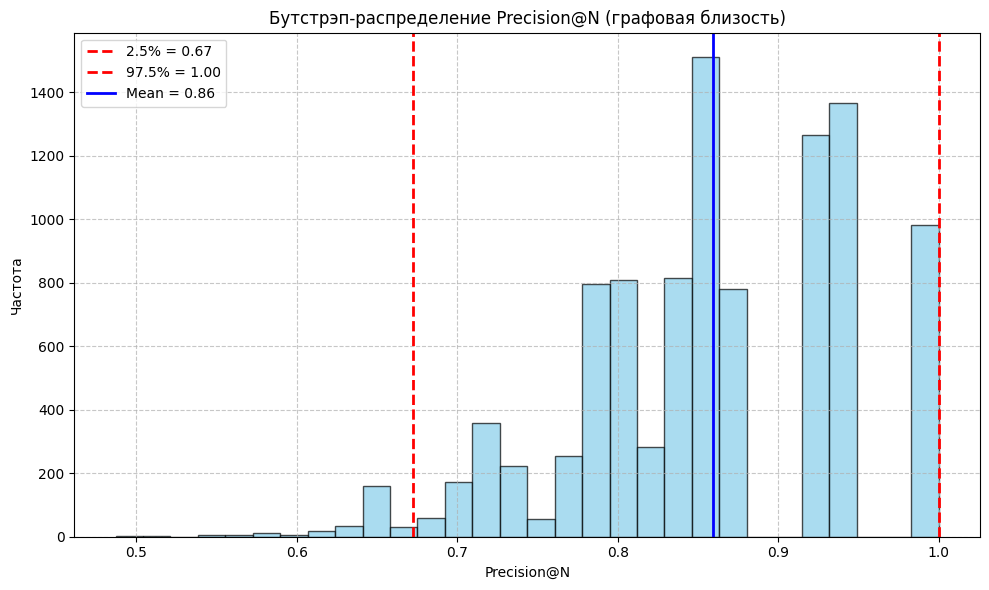

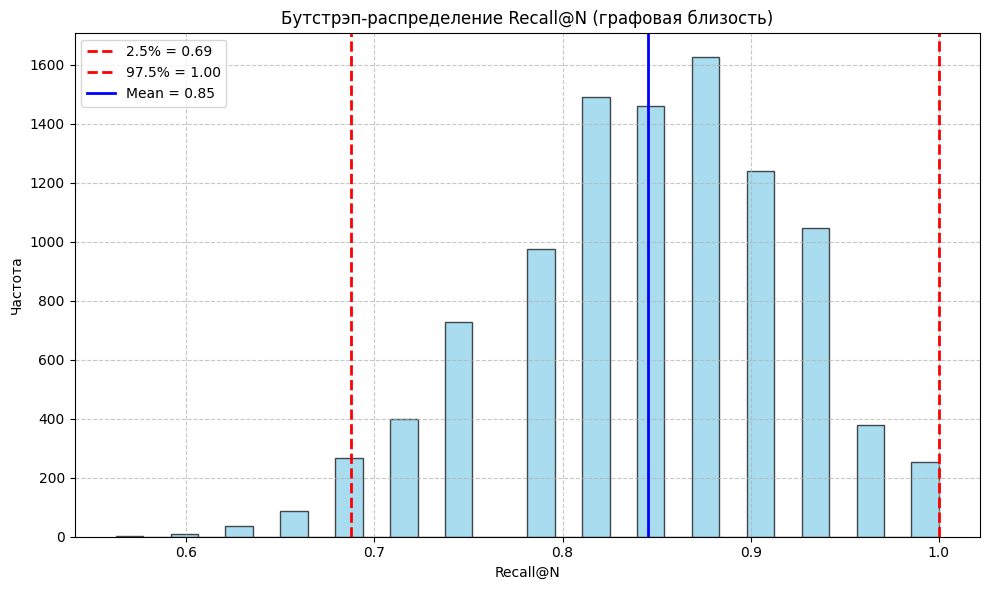

In [ ]:
import matplotlib.pyplot as plt

# Функция графика
def plot_bootstrap(metric_values, metric_name, n_bootstraps=10000):
    np.random.seed(42)
    boot_means = [
        np.mean(np.random.choice(metric_values, size=len(metric_values), replace=True))
        for _ in range(n_bootstraps)
    ]
    lower = np.percentile(boot_means, 2.5)
    upper = np.percentile(boot_means, 97.5)
    mean = np.mean(boot_means)

    plt.figure(figsize=(10, 6))
    plt.hist(boot_means, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    plt.axvline(lower, color='red', linestyle='--', linewidth=2, label=f'2.5% = {lower:.2f}')
    plt.axvline(upper, color='red', linestyle='--', linewidth=2, label=f'97.5% = {upper:.2f}')
    plt.axvline(mean, color='blue', linestyle='-', linewidth=2, label=f'Mean = {mean:.2f}')
    plt.title(f'Бутстрэп-распределение {metric_name} (графовая близость)')
    plt.xlabel(metric_name)
    plt.ylabel('Частота')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Только по навыкам (без "ИТОГО")
metric_values = df.loc[~df["Навык"].str.startswith("ИТОГО"), "Precision@N"].astype(float).dropna().values
plot_bootstrap(metric_values, "Precision@N")

metric_values = df.loc[~df["Навык"].str.startswith("ИТОГО"), "Recall@N"].astype(float).dropna().values
plot_bootstrap(metric_values, "Recall@N")


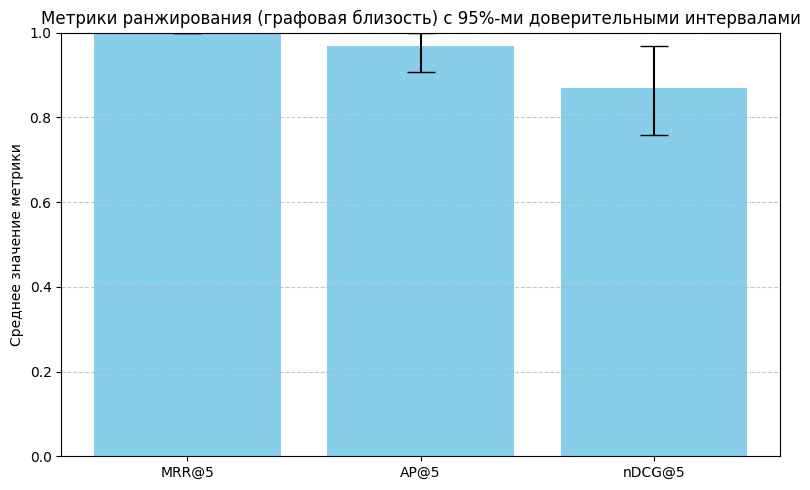

,Навык,MRR@5,AP@5,CG@5,DCG@5,nDCG@5,MRR@5_CI,AP@5_CI,nDCG@5_CI
0,api,1.0,1.0000,1,1.0,0.6131,,,
1,язык программирования r,1.0,1.0000,3,2.1309,0.8319,,,
2,excel,1.0,1.0000,2,1.6309,0.6367,,,
3,power bi,1.0,1.0000,1,1.0,1.0000,,,
4,etl,1.0,1.0000,1,1.0,1.0000,,,
5,большие данные,1.0,1.0000,5,2.9485,1.0000,,,
6,a/b тесты,1.0,0.7500,2,1.4307,0.8772,,,
7,javascript,1.0,1.0000,1,1.0,1.0000,,,
8,ИТОГО,1.0,0.9688,,,0.8699,"[1.0, 1.0]","[0.9062, 1.0]","[0.758, 0.9693]"


In [ ]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from math import log2
from IPython.display import display

# ⚙️ Настройки
K = 5

# Загрузка эталона
ref_df = pd.read_excel("эталонный_датасет.xlsx")
ref_df.dropna(subset=["skill", "course_link"], inplace=True)
reference_dict = ref_df.groupby("skill")["course_link"].apply(set).to_dict()

# Загрузка рекомендаций (графовая близость)
with open("фин_рек_гибридн_sorted.json", "r", encoding="utf-8") as f:
    rec_data = json.load(f)

# Подготовка рекомендаций
rec_dict = {
    entry["UncoveredSkill"]: [c["CourseLink"] for c in entry["SortedCourses"][:K]]
    for entry in rec_data
}

# Метрики
def dcg(relevance):
    return sum((1 / log2(i + 2) if rel else 0) for i, rel in enumerate(relevance))

def ideal_dcg(n_relevant):
    return sum((1 / log2(i + 2)) for i in range(min(n_relevant, K)))

def ap_at_k(relevance):
    hits = 0
    score = 0
    for i, rel in enumerate(relevance):
        if rel:
            hits += 1
            score += hits / (i + 1)
    return score / min(sum(relevance), K) if sum(relevance) else 0

# Расчет метрик
metrics = []
for skill, recs in rec_dict.items():
    true_set = reference_dict.get(skill)
    if not true_set:
        continue

    relevance = [1 if link in true_set else 0 for link in recs]

    mrr = next((1 / (idx + 1) for idx, rel in enumerate(relevance) if rel), 0)
    ap = ap_at_k(relevance)
    cg = sum(relevance)
    dcg_val = dcg(relevance)
    idcg_val = ideal_dcg(len(true_set))
    ndcg = dcg_val / idcg_val if idcg_val > 0 else 0

    metrics.append({
        "Навык": skill,
        "MRR@5": round(mrr, 4),
        "AP@5": round(ap, 4),
        "CG@5": cg,
        "DCG@5": round(dcg_val, 4),
        "nDCG@5": round(ndcg, 4),
    })

# 📌 Bootstrap для интервальных оценок ранжирования
def bootstrap_ci(data, n_bootstraps=10000, ci=95):
    np.random.seed(42)
    boot_samples = [np.mean(np.random.choice(data, size=len(data), replace=True)) for _ in range(n_bootstraps)]
    lower = np.percentile(boot_samples, (100 - ci) / 2)
    upper = np.percentile(boot_samples, 100 - (100 - ci) / 2)
    return round(lower, 4), round(upper, 4)

# Интервальные оценки для агрегированных метрик
# Интервальные оценки для агрегированных метрик
agg_metrics = {"Навык": "ИТОГО"}
intervals = {}
for metric in ["MRR@5", "AP@5", "nDCG@5"]:
    values = [m[metric] for m in metrics if m["Навык"] != "ИТОГО"]  # ← FIX
    mean_val = round(np.mean(values), 4)
    ci_low, ci_high = bootstrap_ci(values)
    agg_metrics[metric] = mean_val
    intervals[metric] = (mean_val, ci_low, ci_high)
    agg_metrics[f"{metric}_CI"] = f"[{ci_low}, {ci_high}]"

agg_metrics.update({"CG@5": "", "DCG@5": ""})
metrics.append(agg_metrics)

# 📊 Визуализация интервальных оценок
fig, ax = plt.subplots(figsize=(8, 5))
metric_names = intervals.keys()
means = [intervals[m][0] for m in metric_names]
lower_bounds = [intervals[m][1] for m in metric_names]
upper_bounds = [intervals[m][2] for m in metric_names]

ax.bar(metric_names, means, yerr=[np.array(means)-np.array(lower_bounds), np.array(upper_bounds)-np.array(means)], capsize=10, color='skyblue')
ax.set_ylabel('Среднее значение метрики')
ax.set_title('Метрики ранжирования (графовая близость) с 95%-ми доверительными интервалами')
ax.set_ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Вывод таблицы
metrics_df = pd.DataFrame(metrics).fillna("")
display(metrics_df)

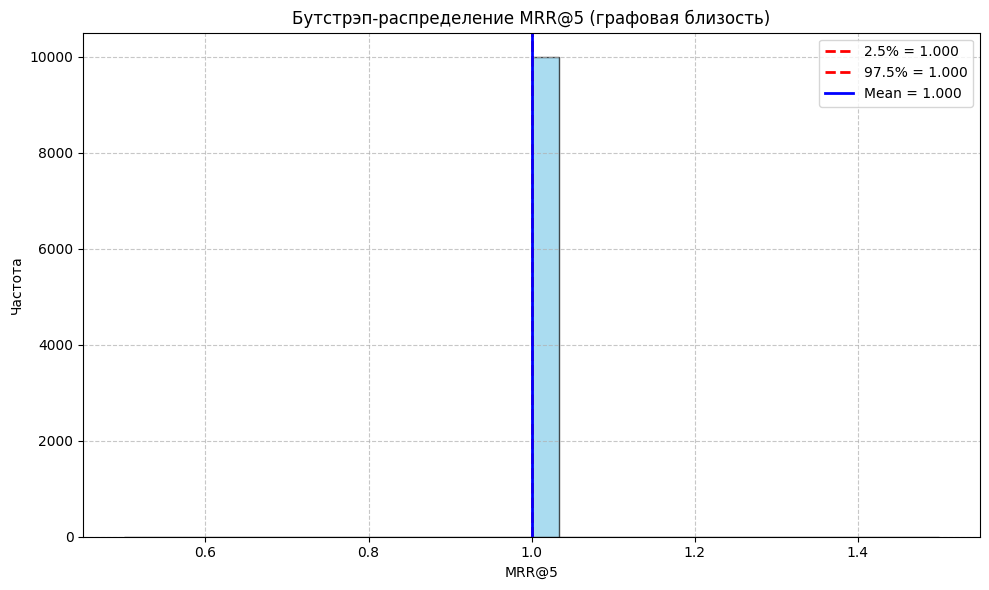

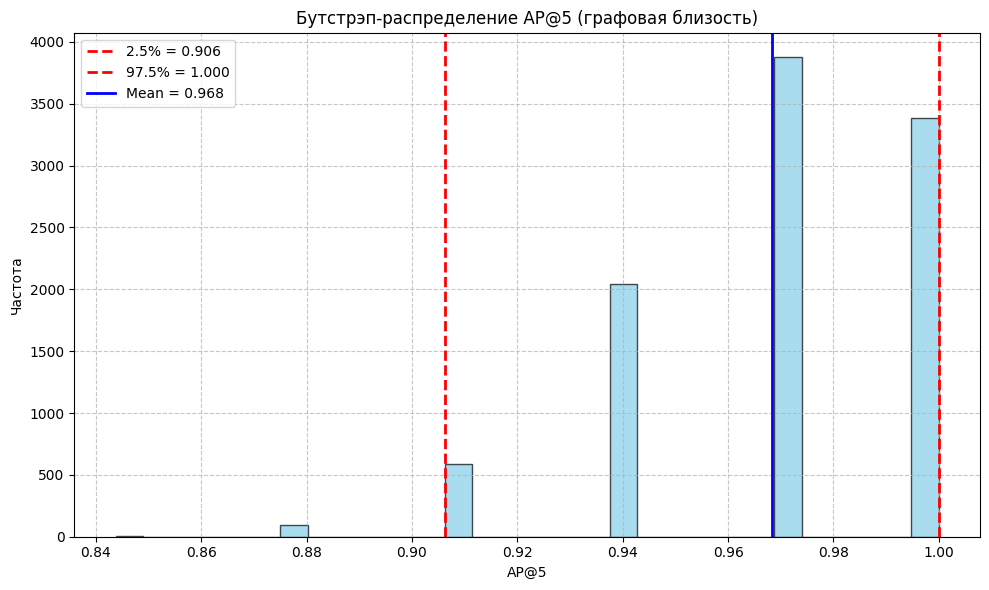

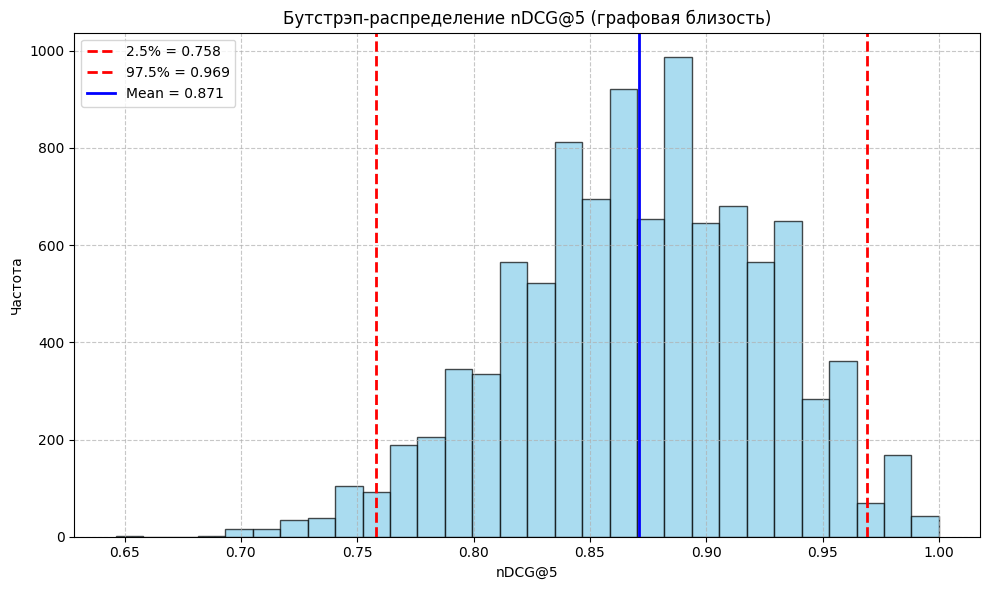

In [ ]:
# 📈 Функция построения распределения бутстрэпа
def plot_bootstrap(metric_values, metric_name, n_bootstraps=10000):
    np.random.seed(42)
    boot_means = [np.mean(np.random.choice(metric_values, size=len(metric_values), replace=True))
                  for _ in range(n_bootstraps)]

    lower = np.percentile(boot_means, 2.5)
    upper = np.percentile(boot_means, 97.5)
    mean = np.mean(boot_means)

    plt.figure(figsize=(10, 6))
    plt.hist(boot_means, bins=30, color='skyblue', edgecolor='black', alpha=0.7)

    plt.axvline(lower, color='red', linestyle='--', linewidth=2, label=f'2.5% = {lower:.3f}')
    plt.axvline(upper, color='red', linestyle='--', linewidth=2, label=f'97.5% = {upper:.3f}')
    plt.axvline(mean, color='blue', linestyle='-', linewidth=2, label=f'Mean = {mean:.3f}')

    plt.title(f'Бутстрэп-распределение {metric_name} (графовая близость)')
    plt.xlabel(metric_name)
    plt.ylabel('Частота')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 📊 Визуализация для всех метрик
for metric in ["MRR@5", "AP@5", "nDCG@5"]:
    values = [m[metric] for m in metrics if m["Навык"] != "ИТОГО"]
    plot_bootstrap(values, metric)
